In [65]:
! python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\downloader.py" \
  --name googlenet-v1,mobilenet-ssd
! python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\converter.py" \
  --name googlenet-v1,mobilenet-ssd \
  --precisions FP16
! copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car.png" .
! copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car_1.bmp" .

################|| Downloading models ||################

========== Downloading C:\Users\yas_s\Documents\Intel\OpenVINO\work\openvino-model-experiment-package\public\googlenet-v1\googlenet-v1.prototxt

========== Downloading C:\Users\yas_s\Documents\Intel\OpenVINO\work\openvino-model-experiment-package\public\googlenet-v1\googlenet-v1.caffemodel
... 1%, 1024 KB, 199 KB/s, 5 seconds passed
... 3%, 2048 KB, 193 KB/s, 10 seconds passed
... 5%, 3072 KB, 213 KB/s, 14 seconds passed
... 7%, 4096 KB, 209 KB/s, 19 seconds passed
... 9%, 5120 KB, 213 KB/s, 24 seconds passed
... 11%, 6144 KB, 207 KB/s, 29 seconds passed
... 13%, 7168 KB, 212 KB/s, 33 seconds passed
... 15%, 8192 KB, 211 KB/s, 38 seconds passed
... 17%, 9216 KB, 215 KB/s, 42 seconds passed
... 19%, 10240 KB, 216 KB/s, 47 seconds passed
... 21%, 11264 KB, 220 KB/s, 51 seconds passed
... 23%, 12288 KB, 229 KB/s, 53 seconds passed
... 25%, 13312 KB, 242 KB/s, 54 seconds passed
... 27%, 14336 KB, 254 KB/s, 56 seconds passed
... 29%,

In [3]:
from openvino.inference_engine import IECore, IENetwork, ExecutableNetwork

In [16]:
# Heatmap visualize utility functions
#
%matplotlib inline

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import maximum_filter

def load_IR_model(model):
    ie = IECore()
    net = ie.read_network(model+'.xml', model+'.bin')
    exenet = ie.load_network(net, 'CPU')
    inblobs =  (list(net.inputs.keys()))
    outblobs = (list(net.outputs.keys()))
    inshapes  = [ net.inputs [i].shape for i in inblobs  ]
    outshapes = [ net.outputs[i].shape for i in outblobs ]
    print('Input blobs: ', inblobs, inshapes)
    print('Output blobs:', outblobs, outshapes)
    return ie, exenet, inblobs, outblobs, inshapes, outshapes

def infer_ocv_image(exenet, inblob_name, image):
    net=exenet.get_exec_graph_info()      # Obtain IENetwork
    inblob  = list(net.inputs.keys())[0]  # Obtain the name of the 1st input blob
    inshape = net.inputs[inblob].shape
    
    img = cv2.resize(image, (inshape[-1], inshape[-2]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose((2,0,1))          # HWC -> CHW, packed pixel -> planar
    res = exenet.infer(inputs={inblob_name:img})
    return res
    
def read_label_text_file(file):
    try:
        label = open(file).readlines()
    except OSError as e:
        label = []
    return label

def find_peaks(hm, filter_size=3, order=0.5):
    print(hm.shape)
    hm = hm.reshape((hm.shape[1:]))
    local_max = maximum_filter(hm, footprint=np.ones((filter_size, filter_size)), mode='constant')
    detected_peaks = np.ma.array(hm, mask=~(hm == local_max))
    
    temp = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
    peaks_index = np.where((temp.mask != True))
    return peaks_index

def display_heatmap(hm, overlay_img=None, normalize=True, threshold_l=-9999, threshold_h=9999, draw_peaks=False, peak_threshold=0.7):
    """
    input:
      hm            : Heatmap in NCHW format
      overlay_img   : (optional) OpenCV image to display with the heatmap
      normalize     : True = normalize the heatmap (0.0-1.0)
      threahold_l, threshold_h : Low and high threshold value to mark lowlight and highlight region
      draw_peaks    : True = Draw peak points
      peak_treshold : Threshold value to detect peaks
    """

    num_channels = hm.shape[1]

    max_grid_x = 3
    
    if num_channels<max_grid_x:
        grid_x = num_channels
        grid_y = 1
    else:
        grid_x = max_grid_x
        grid_y = num_channels // max_grid_x + 1

    pos=1
    plt.figure(figsize=(10,10))
    for ch in range(num_channels):
        print(ch, end='')
        _hm = hm[:,ch,:,:]                # _res = (C,H,W)
        _hm = _hm.transpose((1,2,0))      # CHW -> HWC, planar -> packed pixel

        print(' Raw : min={:.3}, max={:.3}, mean={:.3}'.format(_hm.min(), _hm.max(), _hm.mean()), end='')

        # normalize
        if normalize == True:
            _hm = (_hm-_hm.min())/(_hm.max()-_hm.min())    # Normalize (0.0-1.0)
            print(', Normalized : min={:.3}, max={:.3}, mean={:.3}'.format(_hm.min(), _hm.max(), _hm.mean()), end='')

        print()

        # Mark Highlight and lowlight
        _img = (_hm*255).astype(np.uint8)
        mask_l = np.where(_hm<threshold_l, 255, 0).astype(np.uint8)
        mask_h = np.where(_hm>threshold_h, 255, 0).astype(np.uint8)
        mask_c = cv2.bitwise_not(cv2.bitwise_or(mask_l, mask_h))
        _img   = cv2.bitwise_and(mask_c, _img)
        img_b  = cv2.bitwise_or(_img, mask_l)
        img_r  = cv2.bitwise_or(_img, mask_h)
        img_g  =                _img
        img    = cv2.merge([img_r, img_g, img_b])

        # Display the heatmap over an image (if an image is supplied)
        if not overlay_img is None:
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)
            overlay_img = cv2.resize(overlay_img, (img.shape[1],img.shape[0]))
            img = img//2 + overlay_img//2

        # Find and draw peaks
        marker_color = (0,255,0)
        if draw_peaks == True:
            peaks = find_peaks(hm[:,ch,:,:], order=peak_threshold)
            for y,x in zip(peaks[0], peaks[1]):
                cv2.drawMarker(img, (x, y), marker_color, markerType=cv2.MARKER_TILTED_CROSS, markerSize=2, thickness=1)

        # Display the result
        plt.subplot(grid_y, grid_x, pos)
        plt.title(str(pos-1))
        plt.imshow(img)
        pos+=1

def decode_classification_result(res, top_k=5, label_file='synset_words.txt'):
    # Read class label text file
    labels = read_label_text_file(label_file)

    res = res.flatten()
    idx = np.argsort(res)[::-1]  # index sort (reverse order, large->small)
    for i in range(top_k):
        if len(labels)==0:
            print(i+1, idx[i]+1, res[idx[i]])
        else:
            print(i+1, idx[i]+1, res[idx[i]], labels[idx[i]][:-1])

def decode_ssd_result(res, threshold=0.7):
    res = res.reshape(res.size//7, 7)         # reshape to (x, 7)
    objs = []
    for obj in res:
        imgid, clsid, confidence, x1, y1, x2, y2 = obj
        if confidence>threshold:              # Draw a bounding box and label when confidence>threshold
            objs.append([imgid, clsid, confidence, x1, y1, x2, y2])
    return objs

def draw_ssd_result(objs, img, label_file='voc_labels.txt'):
    # Read class label text file
    labels = read_label_text_file(label_file)

    img_h, img_w, _ = img.shape
    for obj in objs:
        imgid, clsid, confidence, x1, y1, x2, y2 = obj
        x1 = int( x1 * img_w )
        y1 = int( y1 * img_h )
        x2 = int( x2 * img_w )
        y2 = int( y2 * img_h )
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), thickness=2 )
        if len(labels)>0:
            cv2.putText(img, labels[int(clsid)][:-1], (x1, y1), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(0,255,255), thickness=2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

print('Defined OpenVINO model experiment utility functions')

Defined OpenVINO model experiment utility functions


# Image Classification

In [172]:
# Load an IR model
model = 'public/googlenet-v1/FP16/googlenet-v1'
ie, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 224, 224]]
Output blobs: ['prob'] [[1, 1000]]


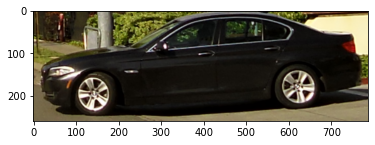

In [173]:
# Load an image and run inference
img_orig = cv2.imread('car.png')
res = infer_ocv_image(exenet, inblobs[0], img_orig)  # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [175]:
# Decode the inference result and display it
decode_classification_result(res[outblobs[0]], top_k=10, label_file='synset_words.txt')

1 480 0.5016654 car wheel
2 818 0.31316656 sports car, sport car
3 437 0.06171181 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
4 512 0.048884775 convertible
5 752 0.02398224 racer, race car, racing car
6 469 0.0146776335 cab, hack, taxi, taxicab
7 718 0.010849829 pickup, pickup truck
8 582 0.0068944264 grille, radiator grille
9 706 0.0022261944 passenger car, coach, carriage
10 637 0.0019383883 mailbag, postbag


# Object detection (SSD)

In [177]:
# Load an IR model
model = 'public/mobilenet-ssd/FP16/mobilenet-ssd'
ie, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 300, 300]]
Output blobs: ['detection_out'] [[1, 1, 100, 7]]


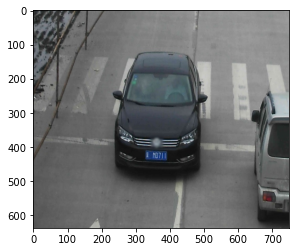

In [178]:
# Load an image and run inference
img_orig = cv2.imread('car_1.bmp')
res = infer_ocv_image(exenet, inblobs[0], img_orig)   # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [179]:
# Decode the inference result and display it
objs = decode_ssd_result(res[outblobs[0]], threshold=0.8)
print('imgid, clsid, prob, x1, y1, x2, y2')
print(objs)

imgid, clsid, prob, x1, y1, x2, y2
[[0.0, 7.0, 0.9999981, 0.30529332, 0.1880557, 0.6763692, 0.7252005], [0.0, 7.0, 0.8729512, 0.85119945, 0.3870977, 0.99222034, 0.95159996]]


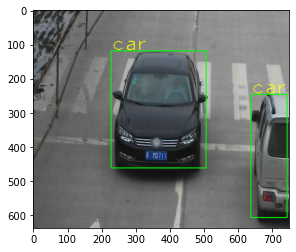

In [180]:
# Display the bbox (bounding box) on the image
draw_ssd_result(objs, img_orig)

# Heatmap (DBFace)

In [5]:
# Load an IR model
model = 'dbface-vga/dbface'
ie, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['x'] [[1, 3, 480, 640]]
Output blobs: ['Conv_525', 'Exp_527', 'Sigmoid_526'] [[1, 10, 120, 160], [1, 4, 120, 160], [1, 1, 120, 160]]


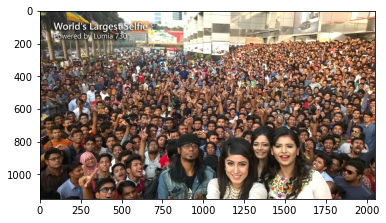

In [6]:
# Load an image and run inference
img_orig = cv2.imread('selfie.jpg')
res = infer_ocv_image(exenet, inblobs[0], img_orig)

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(1, 10, 120, 160)
0 Raw : min=-0.47, max=0.362, mean=-0.0378, Normalized : min=0.0, max=1.0, mean=0.519
1 Raw : min=-0.306, max=0.488, mean=0.107, Normalized : min=0.0, max=1.0, mean=0.519
2 Raw : min=-0.339, max=0.414, mean=0.0348, Normalized : min=0.0, max=1.0, mean=0.496
3 Raw : min=-0.446, max=0.278, mean=-0.0268, Normalized : min=0.0, max=1.0, mean=0.579
4 Raw : min=-0.375, max=0.482, mean=0.0802, Normalized : min=0.0, max=1.0, mean=0.531
5 Raw : min=-0.621, max=0.358, mean=-0.051, Normalized : min=0.0, max=1.0, mean=0.582
6 Raw : min=-0.641, max=0.369, mean=-0.0489, Normalized : min=0.0, max=1.0, mean=0.586
7 Raw : min=-0.446, max=0.484, mean=0.0697, Normalized : min=0.0, max=1.0, mean=0.555
8 Raw : min=-0.19, max=0.564, mean=0.189, Normalized : min=0.0, max=1.0, mean=0.502
9 Raw : min=-0.137, max=0.593, mean=0.19, Normalized : min=0.0, max=1.0, mean=0.448


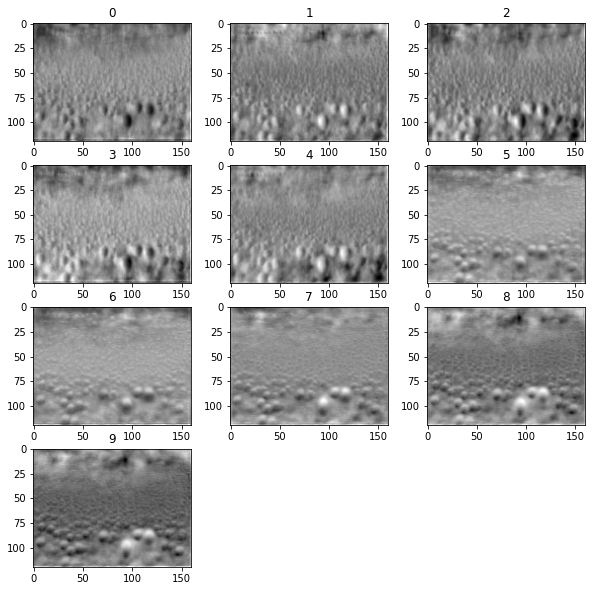

In [7]:
# Display heatmaps
hm = res[outblobs[0]]
print(hm.shape)
display_heatmap(hm)

(1, 1, 120, 160)
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17
(1, 120, 160)


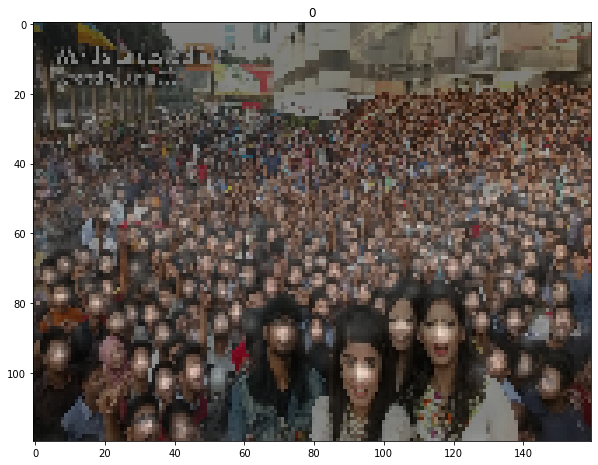

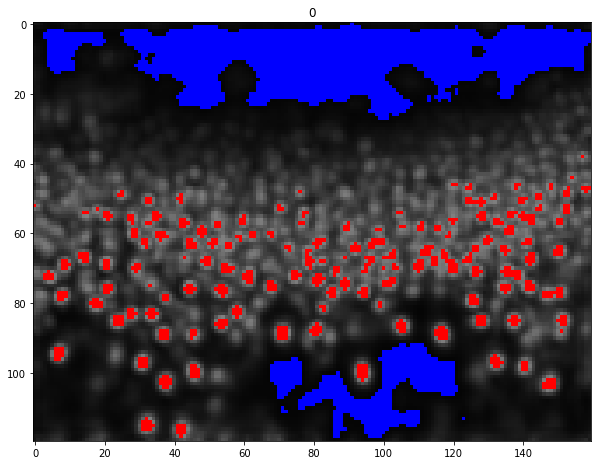

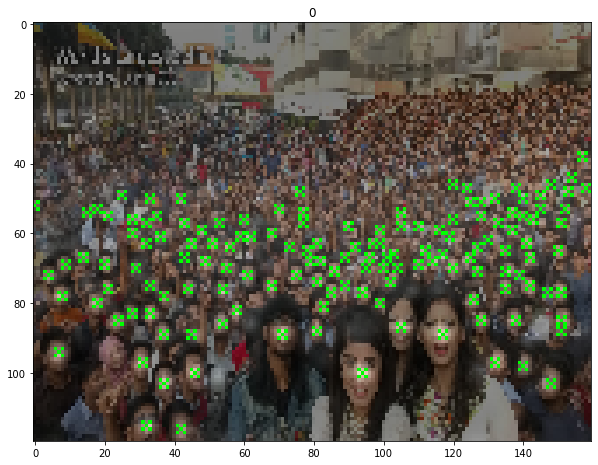

In [18]:
# Display heatmaps
hm = res[outblobs[2]]
print(hm.shape)

#def display_heatmap(hm, overlay_img=None, normalize=True, threshold_l=-9999, threshold_h=9999, draw_peaks=False, peak_threshold=0.7):

display_heatmap(hm, overlay_img=img_orig)

display_heatmap(hm, normalize=True, threshold_l=0.02, threshold_h=0.5)

display_heatmap(hm, overlay_img=img_orig, normalize=True, peak_threshold=0.5, draw_peaks=True)
